# Learning With Errors (LWE)

## import libs

In [1]:
#!conda install pycrypto -y
#!conda install numba -y

In [2]:
import numpy as np
import pandas as pd
import scipy.stats
import math
import itertools
import random
from Crypto.Util import number

import matplotlib.pyplot as plt
from matplotlib import collections as matcoll

import time

%load_ext cython

## Set vector s (secret)

Choose $s \in \mathbb{Z}^m_p$ with arbitrary $m \in \mathbb{N}$

In [3]:
#s = np.array([1, 1, 1]) 
s = np.array([1, 2, 3]) 
#s = np.array([10, 13, 9, 11]) 
#s = np.array([10, 13, 9, 11, 3]) 
n = len(s)

## parameters

In [42]:
number.getPrime(10)

659

Prime: 13
Count of equations: 100
0.05
Mu: 0 	 Sigma: 2


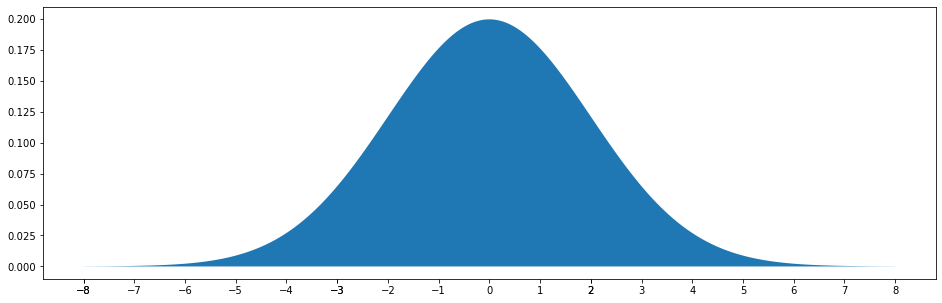

In [4]:
# modulus 
#p = 17  # only prime numbers (it has to be a finite field)
p = number.getPrime(n.bit_length()**2)  # using pycrypto lib  (p = O(n^2))
print("Prime:", p)

#size parameter
m = 100
#m = min(2**(3*n), 200)
print('Count of equations:', m)

# distribution 
## gaussian in this example according to the paper https://cims.nyu.edu/~regev/papers/lwesurvey.pdf (09.11.2021, page 2)
mu = 0
#alpha = 1/(math.sqrt(n)*math.log2(n)**2)   # α = 1/(√n log^2(n))
alpha = 0.05
print(alpha)
sigma = alpha * p  
sigma = 2
print("Mu:", mu, "\t Sigma:", sigma)

## plot the dense function of the distribution
gridPointCount = 10000; delta = 1/gridPointCount
interval = [-4*np.ceil(sigma), 4*np.ceil(sigma)]

x = np.linspace(interval[0], interval[1], gridPointCount)
y = scipy.stats.norm.pdf(x, loc=mu, scale=sigma)

fig, ax = plt.subplots(figsize=(16, 5))
ax.fill_between(x, y)
ax.set_xticks(np.linspace(interval[0], interval[1], 20, dtype = int))
fig.savefig('gaussianPropapation.png')
plt.show()

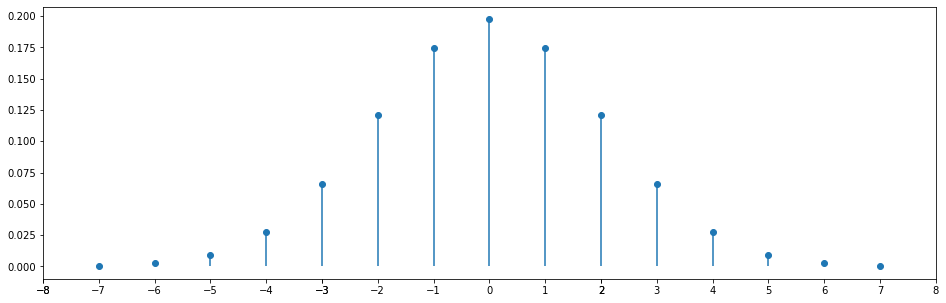

In [5]:
x = np.arange(interval[0]+.5, interval[1]+.5, 1)
y = scipy.stats.norm.cdf(x, loc=mu, scale=sigma)

z = y[1:] - y[:-1] 

fig, ax = plt.subplots(figsize=(16, 5))
ax.stem(x[:-1]+.5, z, basefmt=" ", use_line_collection=True)
ax.set_xticks(np.linspace(interval[0], interval[1], 20, dtype = int))
fig.savefig('roundedGaussianPropapation.png')
plt.show()

## Construct the LWE problem

#### Construct A, b and e 

In [6]:
np.random.seed(42)  # set seed
np.random.randint(0, p)  # uniform distribution (p excluded)
np.random.normal(loc=mu, scale=sigma, size=n)  # gaussian distribution

A = np.random.randint(0, p, size=(m, n))

e = np.rint(np.random.normal(loc=mu, scale=sigma, size=m))  # rounding specified by the IEEE floating point standard IEEE 754 

b = (np.matmul(A, s) + e)%p  # system of linear equations with perturbation

In [7]:
# oracle
def oracleLWE(s, p, n, mu, sigma):
    a = np.random.randint(0, p, size=n)
    
    e = np.rint(np.random.normal(loc=mu, scale=sigma))
    
    b = (a.dot(s) + e)%p
    
    return a, b, e
    
oracleLWE(s, p, n, mu, sigma)

(array([5, 8, 7]), 5.0, 2.0)

In [8]:
%timeit oracleLWE(s, p, n, mu, sigma)

15.3 µs ± 3.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Solving LWE

### Blum-Kalai-Wasserman (BKW)  (variant of https://eprint.iacr.org/2012/636.pdf)

### helper functions

In [9]:
# Iterative Algorithm (xgcd)
def iterative_egcd(a, b):
    x,y, u,v = 0,1, 1,0
    while a != 0:
        q,r = b//a,b%a; m,n = x-u*q,y-v*q # use x//y for floor "floor division"
        b,a, x,y, u,v = a,r, u,v, m,n
    return b, x, y

def modinv(a, m):
    g, x, y = iterative_egcd(a, m) 
    if g != 1:
        return None
    else:
        return x % m
    
def solve_linear_congruence(a, b, m):
    """ Describe all solutions to ax = b  (mod m), or raise ValueError. """
    g = math.gcd(a, m)
    if b % g:
        raise ValueError("No solutions")
    a, b, m = a//g, b//g, m//g
    return modinv(a, m) * b % m, m

def print_solutions(a, b, m):
    print(f"Solving the congruence: {a}x = {b}  (mod {m})")
    x, mx = solve_linear_congruence(a, b, m)
    
    print(f"Particular solution: x = {x}")
    print(f"General solution: x = {x}  (mod {mx})")
    
# for debug
print_solutions(272, 256, 1009)

Solving the congruence: 272x = 256  (mod 1009)
Particular solution: x = 179
General solution: x = 179  (mod 1009)


### Solving algorithm

In [10]:
def furtherElimination(prevCompareVec, subsetDict, guessCountDict, a, b, p):
    equationList = subsetDict.get(prevCompareVec.tobytes())
    for (a_tilde, b_tilde) in equationList:
        compareVec = (a == a_tilde) 
        compareVecNeg = (a == -a_tilde%p)

        if (len(compareVec) - sum(compareVec) == 1):
            a_new = (a - a_tilde) % p
            b_new = (b - b_tilde) % p
            pos = np.nonzero(a_new)[0]
            a_coeff = a_new[pos][0]
            (secret, _) = solve_linear_congruence(a_coeff, b_new, p)
            guessCountDict.get(pos[0]).append(secret)
            #subsetDict.get(compareVec.tobytes()).append((a_new, b_new))  # debug
        else:
            if (len(compareVec) != sum(compareVec)) and (sum(compareVec) > sum(prevCompareVec)):
                a_new = (a - a_tilde) % p
                b_new = (b - b_tilde) % p
                subsetDict.get(compareVec.tobytes()).append((a_new, b_new))
                furtherElimination(compareVec, subsetDict, guessCountDict, a_new, b_new, p)
                
        #continue  # debug    
        if (len(compareVecNeg) - sum(compareVecNeg) == 1):
            a_new = (a + a_tilde) % p
            b_new = (b + b_tilde) % p
            pos = np.nonzero(a_new)[0]
            a_coeff = a_new[pos][0]
            (secret, _) = solve_linear_congruence(a_coeff, b_new, p)
            guessCountDict.get(pos[0]).append(secret)
            #subsetDict.get(compareVecNeg.tobytes()).append((a_new, b_new))  # debug
        else:
            if (len(compareVecNeg) != sum(compareVecNeg)) and (sum(compareVecNeg) > sum(prevCompareVec)):
                a_new = (a + a_tilde) % p
                b_new = (b + b_tilde) % p
                subsetDict.get(compareVecNeg.tobytes()).append((a_new, b_new))
                furtherElimination(compareVecNeg, subsetDict, guessCountDict, a_new, b_new, p)


In [31]:
def solveLWE(s, n, p, mu, sigma):
    # initialize subsets
    subsetDict = dict()
    for item in itertools.product("\x01\x00", repeat=n):
        subsetDict.setdefault(bytes("".join(item), encoding='utf8'), list())

    # initialize error memory
    errorList = list()

    # initialize guess count
    guessCountDict = dict()
    for key in range(n):
        guessCountDict.setdefault(key, list())

    start = time.time()
    for i in range(200):
        a, b, e = oracleLWE(s, p, n, mu, sigma)
        errorList.append(e)

        compareVec = (a == np.zeros(n))
        furtherElimination(compareVec, subsetDict, guessCountDict, a, b, p)

        subsetDict.get(compareVec.tobytes()).append((a, b))
        
    end = time.time()
    print("Processing Time:", end-start)
        
    print(i, [len(elt) for key, elt in subsetDict.items()])
        
    return subsetDict, guessCountDict, errorList

In [ ]:
%%time 
subsetDict, guessCountDict, errorList = solveLWE(s, n, p, mu, sigma)

In [25]:
guess = list()

for key, value in guessCountDict.items():
    try:
        print("Position:", key)
        unique, counts = np.unique(value, return_counts=True)
        significantList = [scipy.stats.binom_test(count, n=len(value), p=1/p, alternative='greater') for count in counts]  # determine significant level
        #print(unique, counts) 
        significantArgMin = np.argmin(significantList)
        print("Min significants:",  significantList[significantArgMin], significantList[significantArgMin]<0.001)
        indexOfMax = np.argmax(counts)
        guessTmp = unique[indexOfMax]
        guess.append(guessTmp)
        print("Guess:", guessTmp)
        print()
    except ValueError:
        pass
    
print()
print()
if (guess==s%p).all():
    print("Guess:", guess, "\t", "Right Solution:", s%p, "\t", "Solved!")
else:
    print("Guess:", guess, "\t", "Right Solution:", s%p, "\t", "Failed!")

Position: 0
Min significants: 0.0 True
Guess: 1.0

Position: 1
Min significants: 0.0 True
Guess: 2.0

Position: 2
Min significants: 0.0 True
Guess: 3.0



Guess: [1.0, 2.0, 3.0] 	 Right Solution: [1 2 3] 	 Solved!


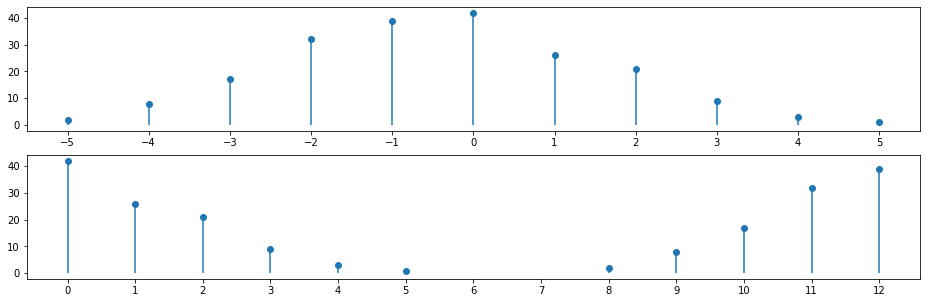

In [26]:
# evaluate error distribution of the concrete LWE instance

fig, ax = plt.subplots(nrows=2, figsize=(16, 5))

unique, counts = np.unique(np.array(errorList), return_counts=True)
ax[0].stem(unique, counts, basefmt=" ", use_line_collection=True)
ax[0].set_xticks(range(round(min(unique)), round(max(unique))+1))

unique, counts = np.unique(np.array(errorList)%p, return_counts=True)
ax[1].stem(unique, counts, basefmt=" ", use_line_collection=True)
ax[1].set_xticks(range(round(min(unique)), round(max(unique))+1))

plt.show()

In [27]:
#error
## mean
print(np.array(errorList).mean())
## std
np.array(errorList).std()

-0.42


1.9062004091910167

Position: 0
[36351 49352 36583 36638 36121 36695 36552 36211 36606 36810 36322 36197
 36472]


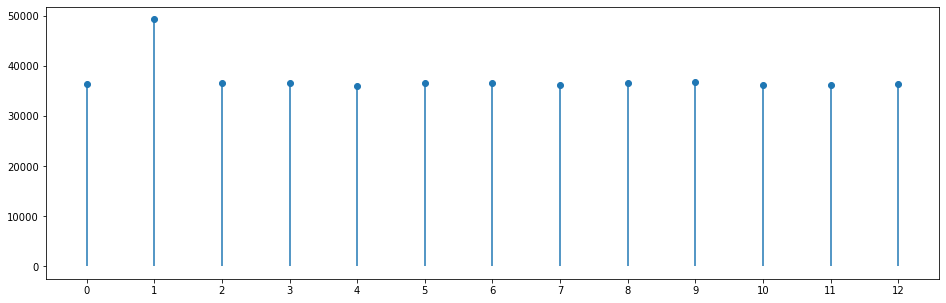

Position: 1
[35255 35029 47803 34875 35314 34948 35511 34926 35703 34918 35169 35052
 35158]


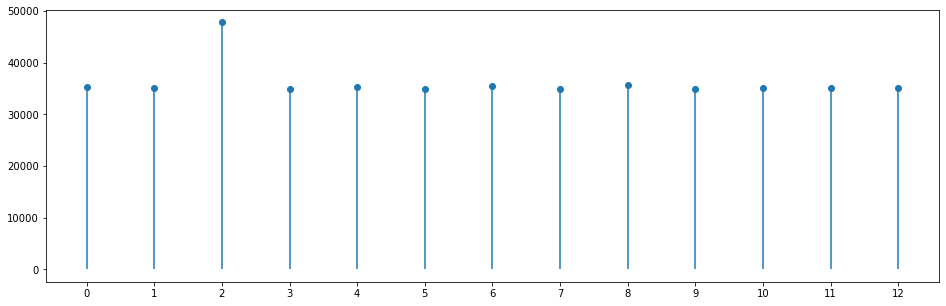

Position: 2
[35498 35230 35804 48550 35429 35683 35405 35513 35879 35705 35678 35728
 35497]


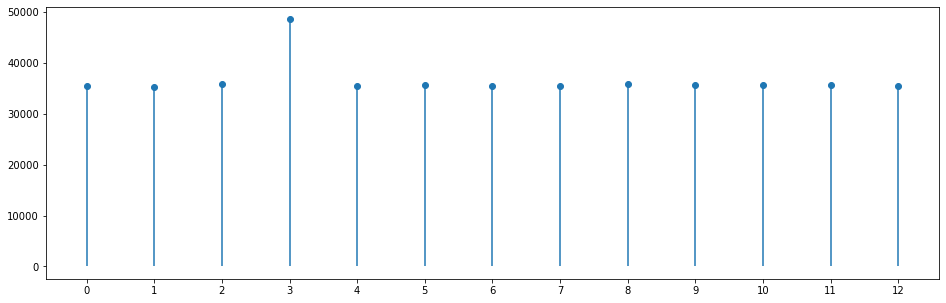

In [30]:
for key, value in guessCountDict.items():
    print("Position:", key)
    unique, counts = np.unique(value, return_counts=True)
    fig, ax = plt.subplots(figsize=(16, 5))
    ax.stem(unique, counts, basefmt=" ", use_line_collection=True)
    ax.set_xticks(range(round(min(unique)), round(max(unique))+1))
    plt.show()

In [29]:
import statistics 
# positions of the solution
for key, value in guessCountDict.items():
    print("Position:", key)
    ## mean
    print(statistics.mean(value))
    ## std
    print(statistics.stdev(value))
    
    print()

Position: 0
5.866318210757635
3.7761477481197243

Position: 1
5.893288989292277
3.7461888133788905

Position: 2
5.924673937497766
3.7211277471015007

